# Plot figure 2

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [2]:
# figure configuration
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('notebook')
sns.set_style("ticks")

## Data preparation

### Definitions

In [3]:
# dictionary definitions

data_dic = {0: "roads_continent_data_18-23_ai.json",
            1: "roads_africa_states_18-23_ai.json",
            2: "roads_northamerica_states_18-23_ai.json",
            3: "roads_europe_states_18-23_ai.json",
            4: "roads_asia_states_18-23_ai.json",}
geojson_folder_dic = {0: "geojson-continent-states",
                      1: "geojson-africa-states",
                      2: "geojson-northamerica-states",
                      3: "geojson-europe-states",
                      4: "geojson-asia-states",}

In [4]:
# user input definition 

while True:
    try:
        user_d_spec = int(input("Which data do you want to plot?\
                            Enter 0 for stats by continents (2018–2023),\
                            1 for stats by Africa states (2018–2023),\
                            2 for stats by North-Central America states (2018–2023),\
                            3 for stats by Europe states (2018–2023),\
                            4 for stats by Asia states (2018–2023):"
                            ))
    except ValueError:
        print("Please enter a number.")
        continue
    if user_d_spec not in range(len(data_dic)):
        print("Please enter 0, 1, 2, 3 or 4.")
        continue
    break


In [5]:
# function definitions

def data_spec(data_dic):
    
    try:
        with open(f"downloaded-data\\{data_dic[user_d_spec]}", "r") as f:
            data = json.load(f)
        return data
    except Exception as e:
        print(e)
        print("Please download the data first.")


def get_geojson_names(home_dir, geojson_folder_dic):
    geojson_dir = os.path.join(home_dir, geojson_folder_dic[user_d_spec], "")

    geojson_names = []
    for (dir_path, dir_names, file_names) in os.walk(geojson_dir):  # give the path
        geojson_names.extend(file_names)
    print(geojson_names)
    return geojson_names


### Load the data

In [6]:
os.chdir('..')

data = data_spec(data_dic)

home_dir = os.getcwd()


### Edit the obtained data into desired shape to create a DataFrame

In [7]:
d = {
    "feature": [],
    "source": [],
    "timestamp": [],
    "value": []
}


In [8]:
for region in data:
    for dic1 in region:
        feature, source = dic1["groupByObject"][0], dic1["groupByObject"][1]
        for res in dic1["result"]:
            d["feature"].append(feature)
            d["source"].append(source)
            d["timestamp"].append(res["timestamp"])
            d["value"].append(res["value"])

df = pd.DataFrame(d)
# df

In [9]:
# extract only the year
df["year"] = pd.to_datetime(df["timestamp"]).dt.year

### Append the names of the regions to the DataFrame

In [10]:
# extract the geojson IDs and the names
geojson_names = get_geojson_names(home_dir, geojson_folder_dic)


['0_Indonesia.geojson', '10_Bhutan.geojson', '11_Oman.geojson', '12_Uzbekistan.geojson', '13_Kazakhstan.geojson', '14_Tajikistan.geojson', '15_Mongolia.geojson', '16_Russia.geojson', '17_Vietnam.geojson', '18_Cambodia.geojson', '19_United Arab Emirates.geojson', '1_Malaysia.geojson', '20_Georgia.geojson', '21_Azerbaijan.geojson', '22_Turkey.geojson', '23_Laos.geojson', '24_Kyrgyzstan.geojson', '25_Armenia.geojson', '26_Iraq.geojson', '27_Iran.geojson', '28_Qatar.geojson', '29_Saudi Arabia.geojson', '2_Cyprus.geojson', '30_Pakistan.geojson', '31_Thailand.geojson', '32_Kuwait.geojson', '33_Timor-Leste.geojson', '34_Brunei.geojson', '35_Myanmar.geojson', '36_Bangladesh.geojson', '37_Afghanistan.geojson', '38_Turkmenistan.geojson', '39_Jordan.geojson', '3_India.geojson', '40_Nepal.geojson', '41_Yemen.geojson', '42_N. Cyprus.geojson', '43_Cyprus U.N. Buffer Zone.geojson', '44_Siachen Glacier.geojson', '45_Philippines.geojson', '46_Sri Lanka.geojson', '47_Taiwan.geojson', '48_Japan.geojson',

In [11]:
geojson_names_2 = geojson_names
# using lib RegularExpression to separate the ID number and the state name
id_name_dic = {int(re.search(r'^\d+', k)[0]): re.search(r'\_.+\.', v)[0][1:-1]
                for k, v in zip(geojson_names, geojson_names_2)}
id_name_ser = pd.Series(id_name_dic)
id_name_df = pd.DataFrame(id_name_ser, columns=["name"])
id_name_df = id_name_df.reset_index().rename(columns={"index": "id"})
id_name_df["id"] = id_name_df["id"].astype(int)
# id_name_df


In [12]:
# merge df with region names based on ids
df = df.merge(id_name_df, how="left", left_on="feature",
               right_on="id")
# df.head()

### Filtering the data

In [13]:
# exclude states which give zero in total
df = df.groupby("name").filter(
    lambda x: x["value"].sum() != 0)

In [14]:
# get the length of AI Microsoft (source=maxar) / manually mapped (remainder) roads for every year
grouped = df.groupby(["source", "year"])["value"].sum()
# grouped


In [15]:
# merge the DataFrame with groupBy DataFrame and compute the percentage
merged_data = df.merge(grouped, on=["source", 'year'], how='left', )
merged_data = merged_data.rename(columns={"value_x":"len_of_roads", "value_y":"total_roads"})
merged_data["percentage"] = (merged_data["len_of_roads"] / merged_data["total_roads"]) * 100
# merged_data.head(10)


In [16]:
# percentage verification
merged_data.groupby(["source", "year"])["percentage"].sum()


source        year
remainder     2018    100.0
              2019    100.0
              2020    100.0
              2021    100.0
              2022    100.0
              2023    100.0
source=maxar  2018      0.0
              2019      0.0
              2020    100.0
              2021    100.0
              2022    100.0
              2023    100.0
Name: percentage, dtype: float64

In [17]:
# create the dataframe by the source
# remainder = manually mapped roads
df_rem = merged_data.loc[(merged_data["source"] == "remainder"), :]
# buiildings used from Microsoft AI
df_ai = merged_data.loc[(merged_data["source"] == "source=maxar"), :]
# df_ai.head()


In [18]:
# exclude states which give zero/any number in total
df_rem = df_rem.groupby("name").filter(lambda x: x["len_of_roads"].sum() != 0)
# Asia: 10 000 000 m, Europe 1000 000 m
df_ai = df_ai.groupby("name").filter(lambda x: x["len_of_roads"].sum() > 100000000)


In [19]:
# verify the sum
# df_rem.groupby("name")["len_of_roads"].sum().sort_values(ascending=True)


In [20]:
# verify the sum
# df_ai.groupby("name")["len_of_roads"].sum().sort_values(ascending=True)

In [21]:
# how the DataFrame looks like – manually mapped roads
df_rem.head()

,feature,source,timestamp,len_of_roads,year,id,name,total_roads,percentage
0,0,remainder,2018-01-01T00:00:00Z,4.125735e+08,2018,0,Indonesia,1.318454e+10,3.129222
1,0,remainder,2019-01-01T00:00:00Z,7.293357e+08,2019,0,Indonesia,1.517844e+10,4.805077
2,0,remainder,2020-01-01T00:00:00Z,1.096717e+09,2020,0,Indonesia,1.694888e+10,6.470739
3,0,remainder,2021-01-01T00:00:00Z,1.206910e+09,2021,0,Indonesia,1.890248e+10,6.384931
4,0,remainder,2022-01-01T00:00:00Z,1.246754e+09,2022,0,Indonesia,2.013083e+10,6.193257


In [22]:
# how the DataFrames look like – AI Microsoft roads
df_ai.head()

,feature,source,timestamp,len_of_roads,year,id,name,total_roads,percentage
102,17,source=maxar,2018-01-01T00:00:00Z,0.000000e+00,2018,17,Vietnam,0.000000e+00,NaN
103,17,source=maxar,2019-01-01T00:00:00Z,0.000000e+00,2019,17,Vietnam,0.000000e+00,NaN
104,17,source=maxar,2020-01-01T00:00:00Z,2.309823e+04,2020,17,Vietnam,1.129495e+05,20.450045
105,17,source=maxar,2021-01-01T00:00:00Z,5.231692e+07,2021,17,Vietnam,2.038471e+08,25.664779
106,17,source=maxar,2022-01-01T00:00:00Z,1.133991e+08,2022,17,Vietnam,9.127416e+08,12.424005


## Plots

### Manually mapped roads

In [23]:
# verify the sum
# df_rem.groupby("year")["len_of_roads"].sum().loc[2023] == df_rem.loc[df_rem["year"] == 2023, "total_roads"]


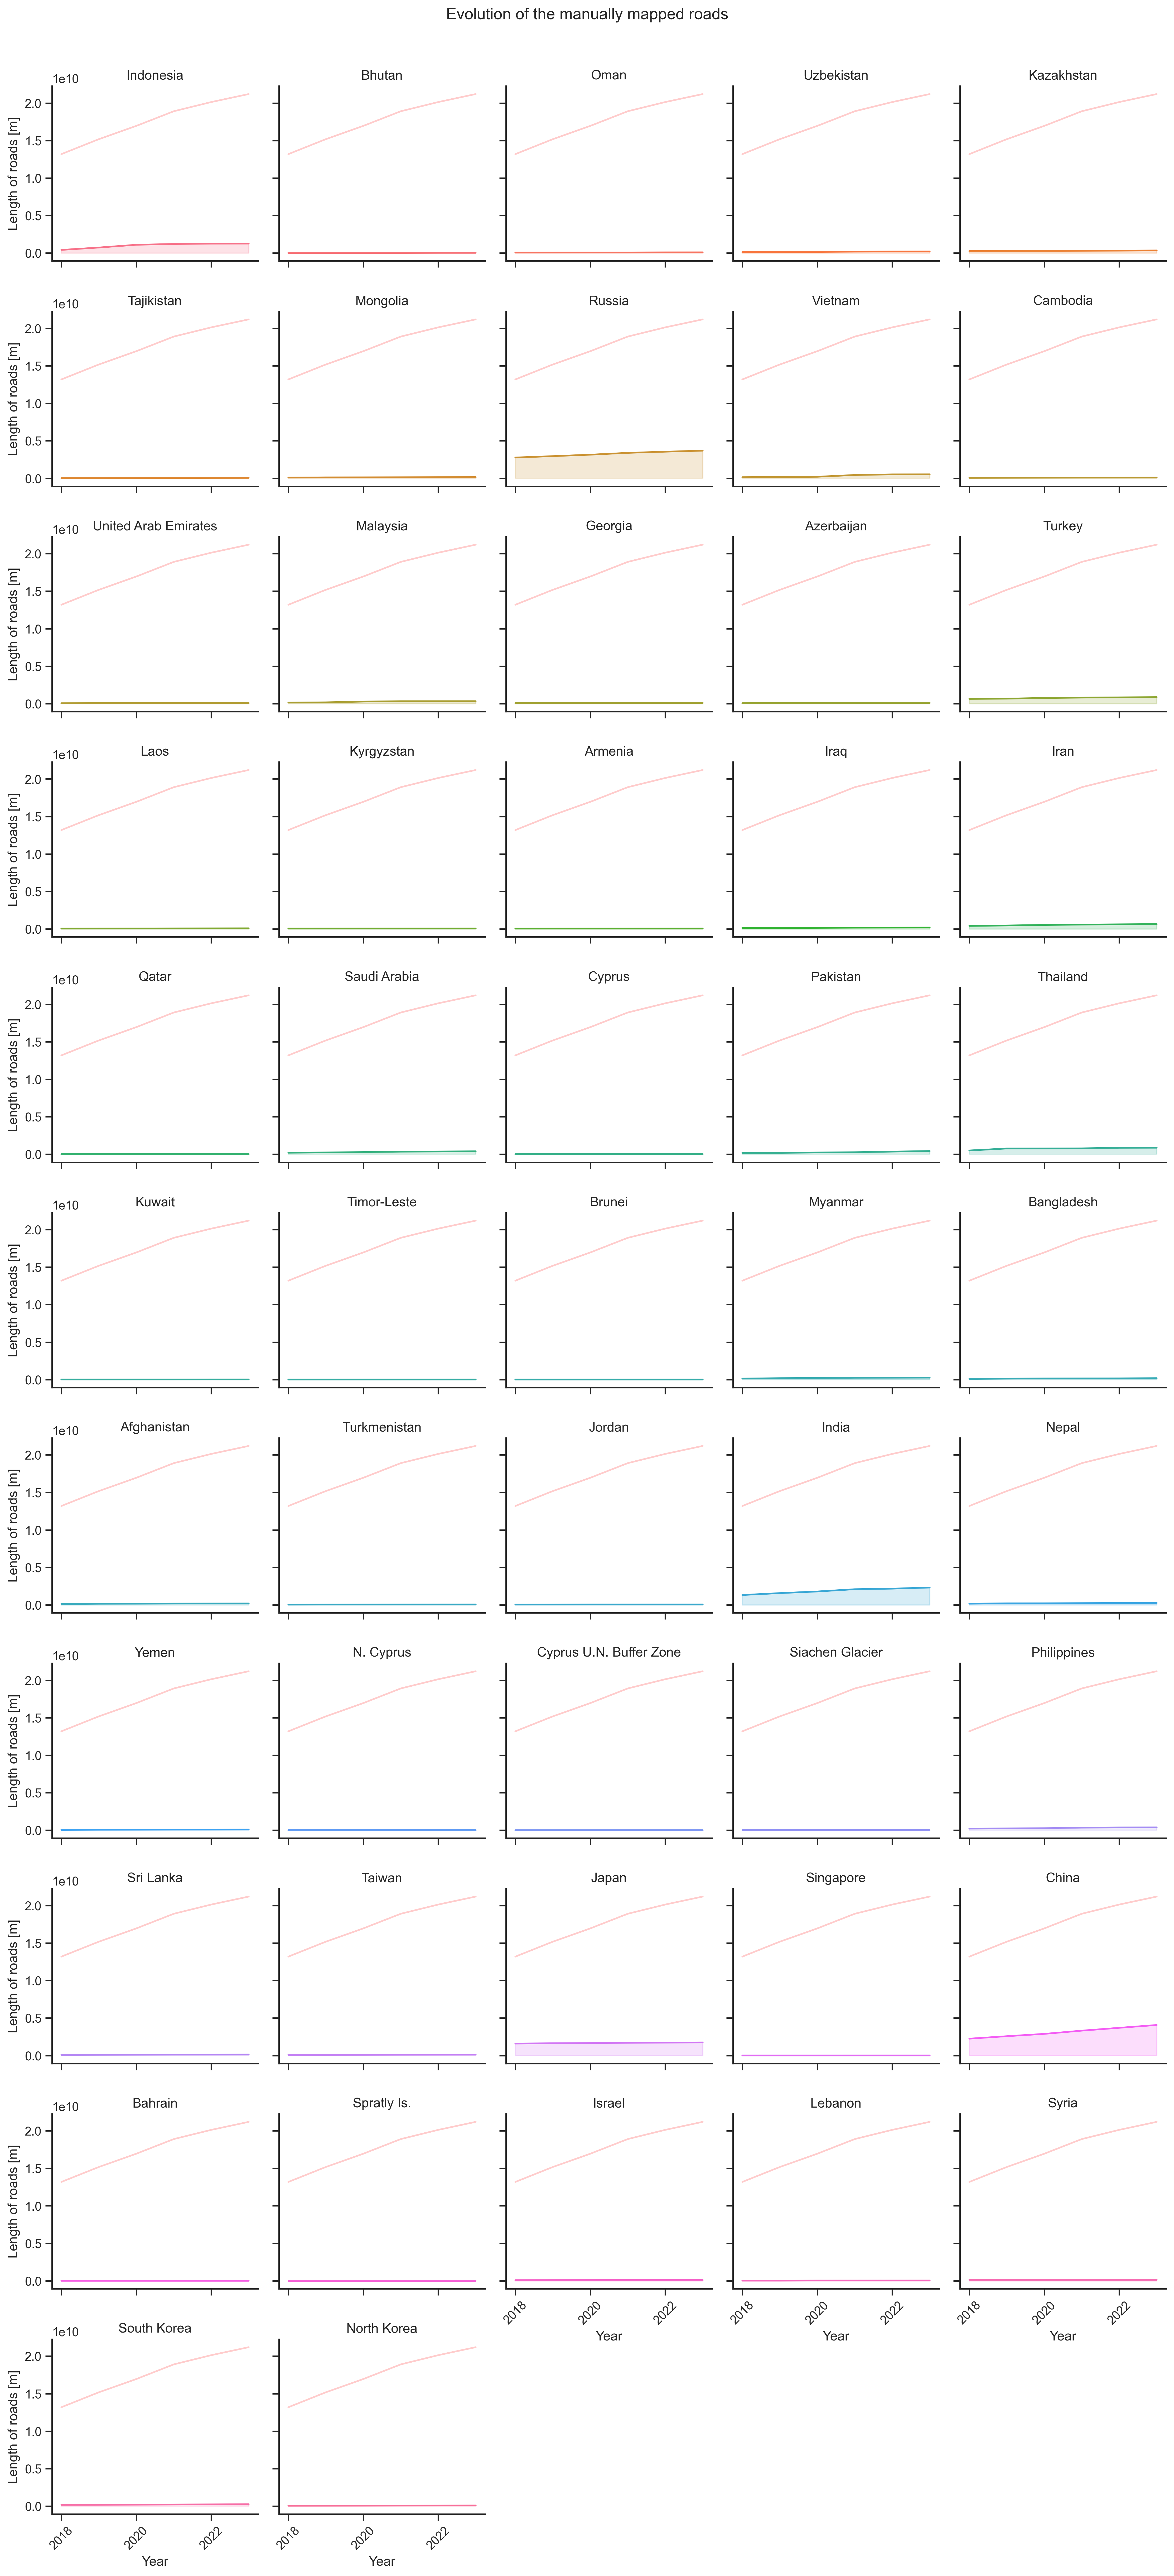

In [24]:
# create a grid : initialize it
g = sns.FacetGrid(df_rem, col='name', hue='name', col_wrap=5, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'len_of_roads')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'len_of_roads',
          alpha=0.2)

# plot the sum line over the plot
g = g.map(plt.plot, 'year', 'total_roads', color='red', alpha=0.2)

# # fill the area with fill_between
# g = g.map(plt.fill_between, 'year', 'total_roads',
#           alpha=0.2)

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Evolution of the manually mapped roads')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Length of roads [m]")
    # ax.set_ylim(100)

# show the graph
plt.show()


#### Try to add summary plot

In [25]:
df_rem_tot = df_rem.groupby("year")["total_roads"].last().reset_index()
df_rem_tot

,year,total_roads
0,2018,1.318454e+10
1,2019,1.517844e+10
2,2020,1.694888e+10
3,2021,1.890248e+10
4,2022,2.013083e+10
5,2023,2.119682e+10


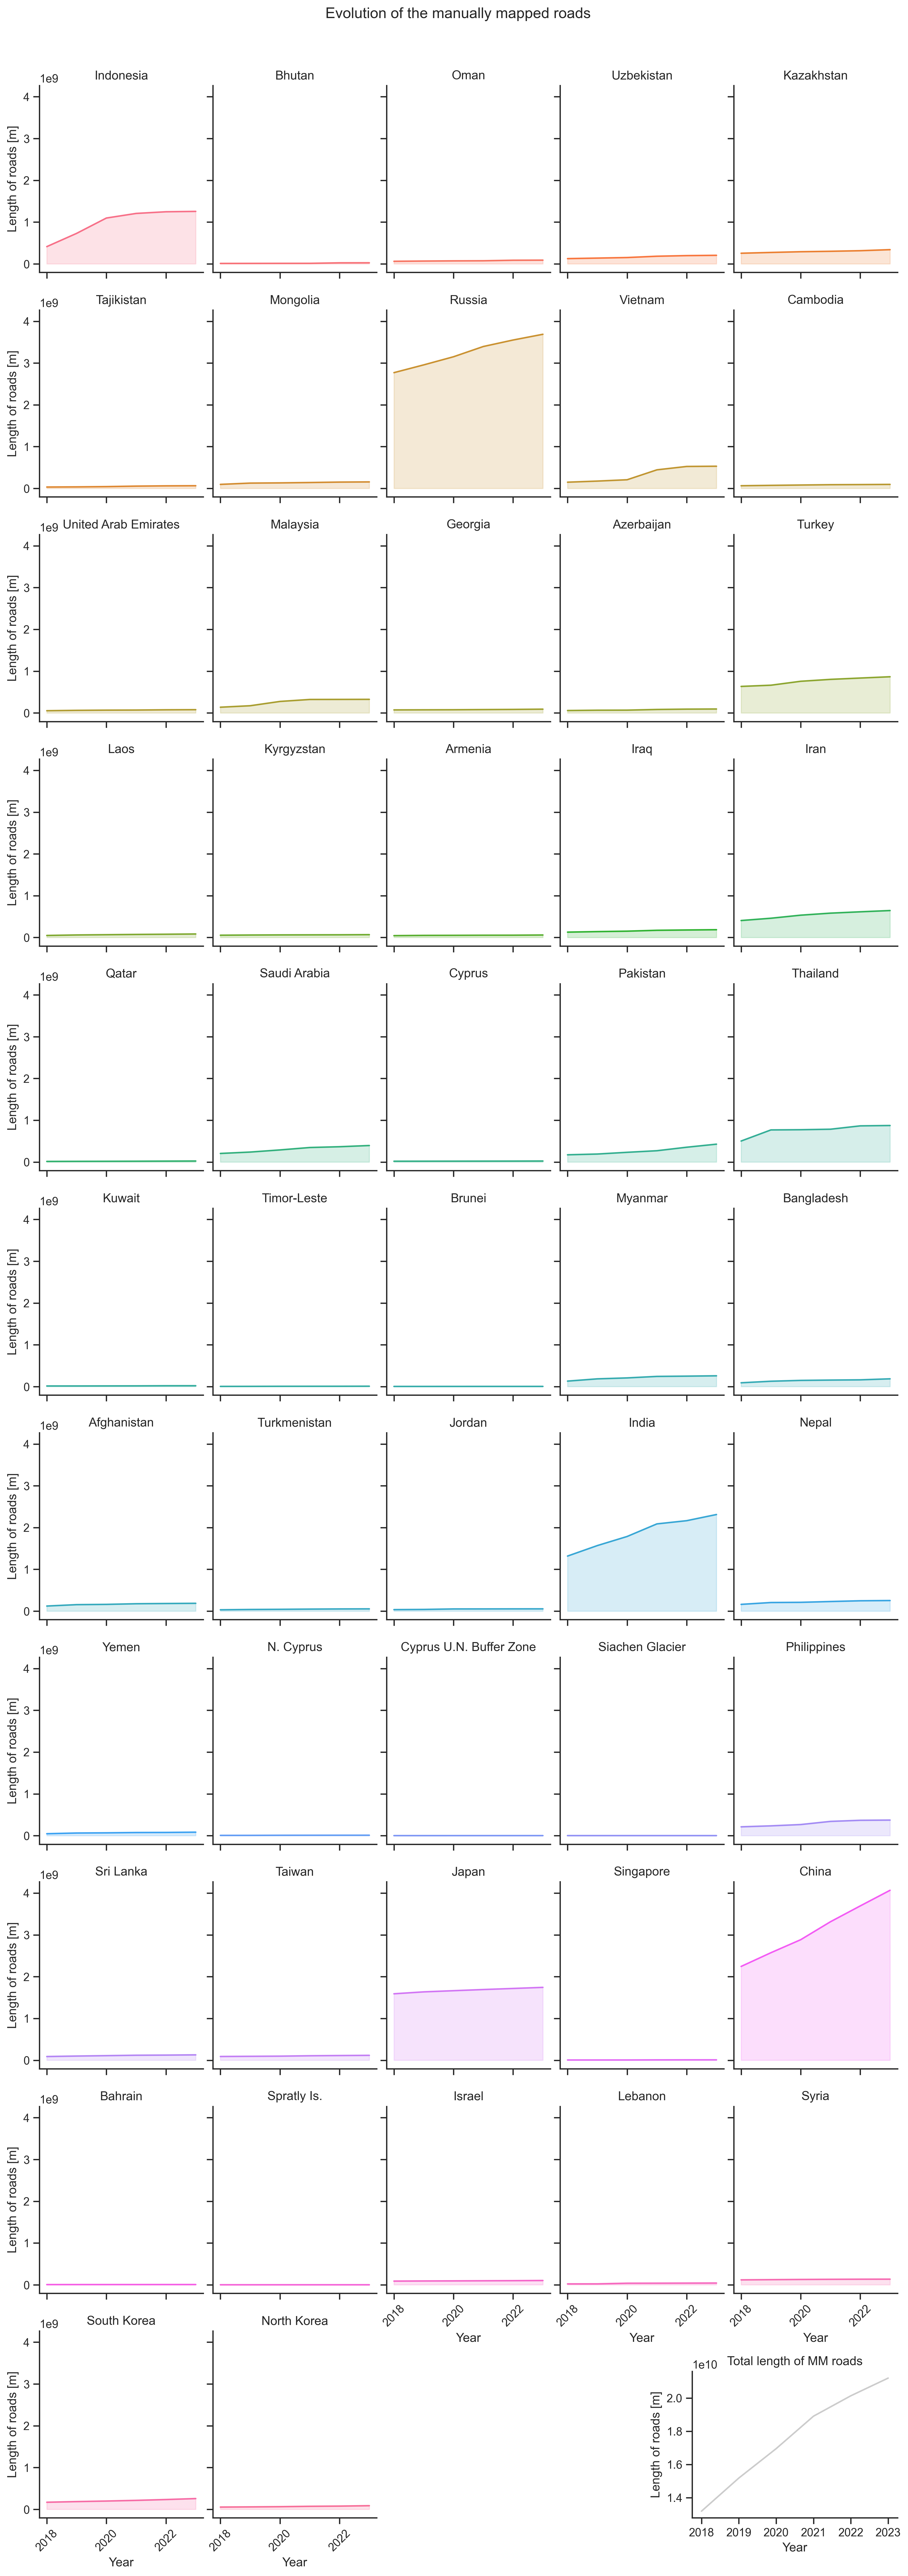

In [26]:
# create a FacetGrid for the first dataframe
g = sns.FacetGrid(df_rem, col='name', hue='name',
                  col_wrap=5, 
                  height=4, aspect=1.2,
                  # gridspec_kws={"wspace": 0.5}
                  )


# plot the data on the FacetGrid
g = g.map(plt.plot, 'year', 'len_of_roads')
g = g.map(plt.fill_between, 'year', 'len_of_roads', alpha=0.2)

# set the x-axis labels to be rotated
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set the titles for each subplot based on the 'name' column
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Evolution of the manually mapped roads')

# set the axes titles and limits
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Length of roads [m]")
    # ax.set_ylim(100)

# create a new plot axis for the second dataframe
ax2 = plt.subplot(14, 4, 56)

# plot the data from the second dataframe on the new axis
sns.lineplot(data=df_rem_tot, x='year',
             y='total_roads', color='black', alpha=0.2, ax=ax2)

# set the title and axes labels for the new plot axis
ax2.set_title('Total length of MM roads')
ax2.set_xlabel('Year')
ax2.set_ylabel('Length of roads [m]')

# remove the top and right spines of all subplots
sns.despine()

# adjust the layout of the subplots
# plt.tight_layout()

# adjust the size of the figure
fig = plt.gcf()
fig.set_size_inches(12, 35)

# plt.legend()

# show the plot
plt.show()


### AI Microsoft roads

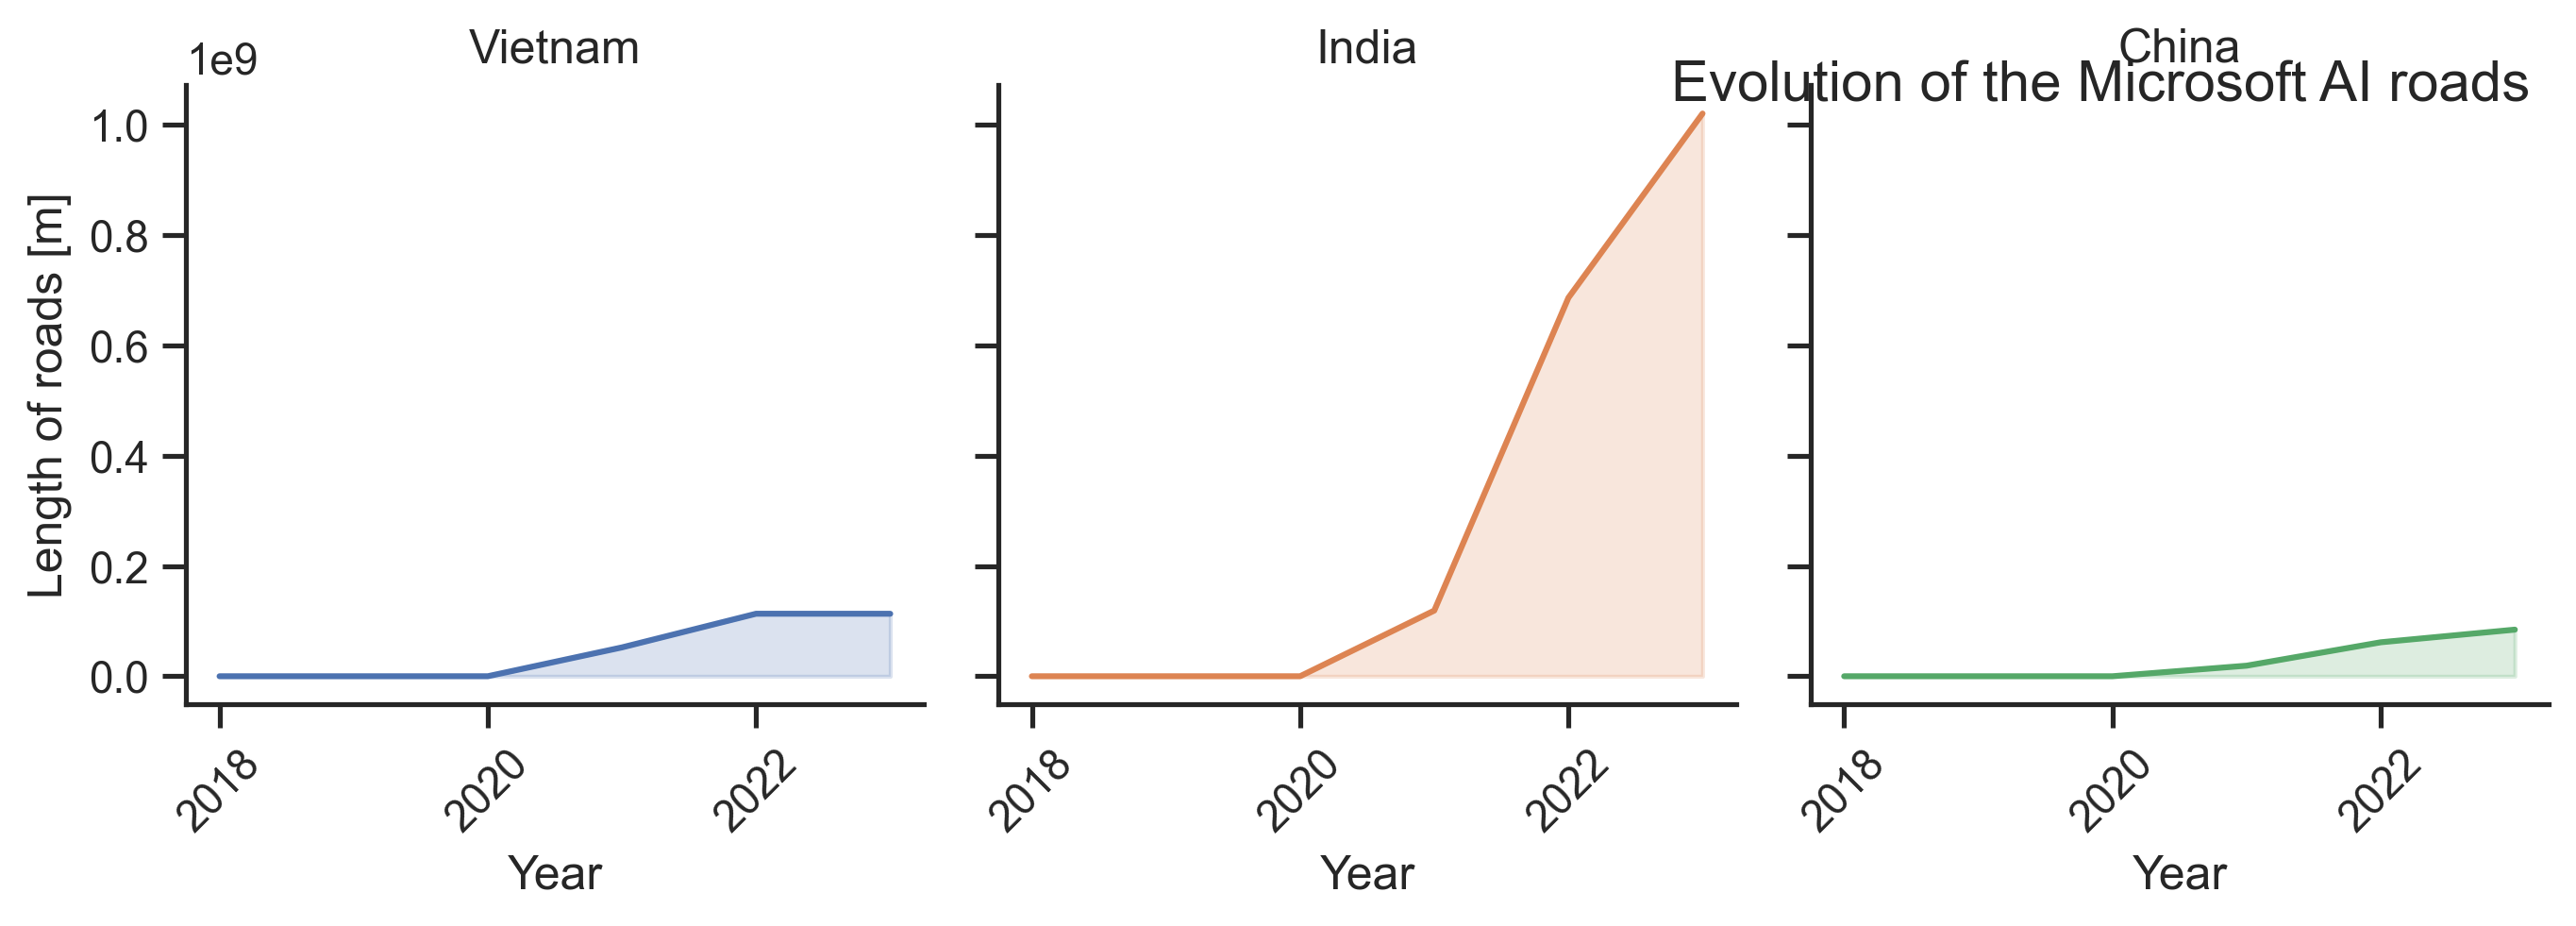

In [27]:
# create a grid : initialize it
g = sns.FacetGrid(df_ai, col='name', hue='name', col_wrap=5, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'len_of_roads')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'len_of_roads', alpha=0.2)
# g = g.map(lambda data, **kwargs:
#           plt.fill_between(data['year'], data['len_of_roads'],
#                            where=(data['frame'] == 'df_rem'),
#                            alpha=0.2, **kwargs), 'year')

# plot the sum line over the plot
# g = g.map(plt.plot, 'year', 'total_roads', color='red', alpha=0.2)

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Evolution of the Microsoft AI roads')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Length of roads [m]")
    # ax.set_ylim(100)

# plt.legend()

# show the graph
plt.show()


#### Try to add AI summary plot

In [28]:
df_ai_tot = df_ai.groupby("year")["total_roads"].last().reset_index()
df_ai_tot

,year,total_roads
0,2018,0.000000e+00
1,2019,0.000000e+00
2,2020,1.129495e+05
3,2021,2.038471e+08
4,2022,9.127416e+08
5,2023,1.351313e+09


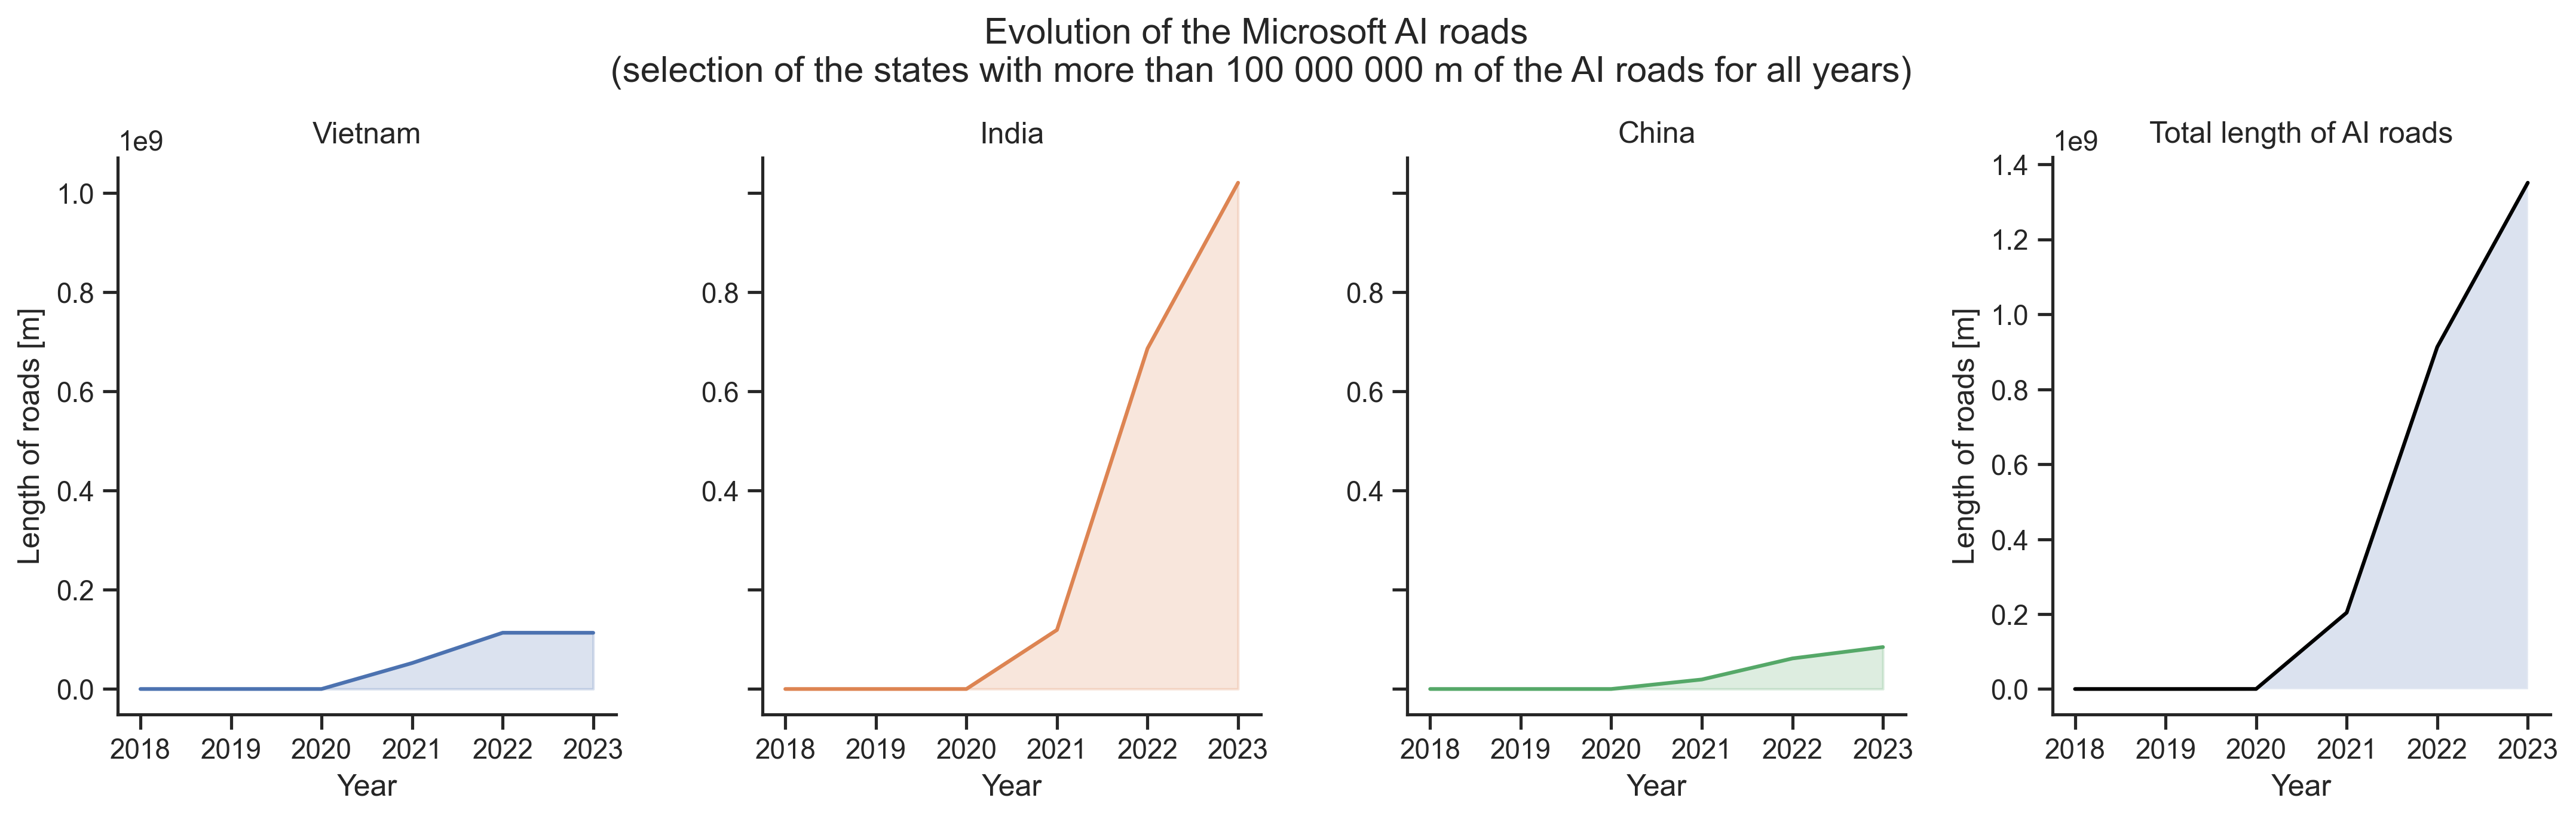

In [48]:
# create a FacetGrid for the first dataframe
g = sns.FacetGrid(df_ai, col='name', hue='name',
                  col_wrap=4, height=2, aspect=1.2)

# plot the data on the FacetGrid
g = g.map(plt.plot, 'year', 'len_of_roads')
g = g.map(plt.fill_between, 'year', 'len_of_roads', alpha=0.2)

# set the x-axis labels to be rotated
[plt.setp(ax.get_xticklabels(), rotation=0) for ax in g.axes.flat]

# set the titles for each subplot based on the 'name' column
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.85)
g.fig.suptitle(
    'Evolution of the Microsoft AI roads\n (selection of the states with more than 100 000 000 m of the AI roads for all years)')

# set the axes titles and limits
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Length of roads [m]")
    # ax.set_ylim(100)

# create a new plot axis for the second dataframe
ax2 = plt.subplot(1, 4, 4)

# plot the data from the second dataframe on the new axis
sns.lineplot(data=df_ai_tot, x='year',
             y='total_roads', color='black', alpha=1)
plt.fill_between(df_ai_tot['year'], df_ai_tot['total_roads'], alpha=0.2)

# set the title and axes labels for the new plot axis
ax2.set_title('Total length of AI roads')
ax2.set_xlabel('Year')
ax2.set_ylabel('Length of roads [m]')

# remove the top and right spines of all subplots
sns.despine()

# adjust the layout of the subplots
# plt.tight_layout()

# adjust the size of the figure
fig = plt.gcf()
fig.set_size_inches(15, 6)

# ax.legend(loc='upper left', bbox_to_anchor=(3, 0.5))

# show the plot
plt.show()


### AI Microsoft and Manually mapped roads together

In [30]:
# data = pd.concat([df_rem.assign(frame="MM"), df_ai.assign(frame="AI")])

In [31]:
df_rem["name"].isin(df_ai["name"]).value_counts()

False    294
True      18
Name: name, dtype: int64

In [32]:
merged_s = pd.merge(df_rem, df_ai, on=["name", "year"], how="inner", )


In [33]:
merged_x = merged_s.drop(['feature_y', 'source_y', 'timestamp_y', 'len_of_roads_y', 'id_y','total_roads_y', 'percentage_y'], axis=1)
merged_y = merged_s.drop(['feature_x', 'source_x', 'timestamp_x', 'len_of_roads_x','id_x', 'total_roads_x', 'percentage_x'], axis = 1)

In [34]:
rename_col_x = {
    'feature_x': 'feature',
    'source_x': 'source',
    'timestamp_x': 'timestamp',
    'len_of_roads_x': 'len_of_roads',
    # 'year_x': 'year',
    'id_x': 'id',
    'total_roads_x': 'total_roads',
    'percentage_x': 'percentage'
}

rename_col_y = {
    'feature_y': 'feature',
    'source_y': 'source',
    'timestamp_y': 'timestamp',
    'len_of_roads_y': 'len_of_roads',
    # 'year_y': 'year',
    'id_y': 'id',
    'total_roads_y': 'total_roads',
    'percentage_y': 'percentage'
}


In [35]:
merged_x = merged_x.rename(columns=rename_col_x)
merged_y = merged_y.rename(columns=rename_col_y)

In [36]:
data = pd.concat([merged_x.assign(frame="MM"),
                  merged_y.assign(frame="AI")])


In [37]:
data["name"].unique()

array(['Vietnam', 'India', 'China'], dtype=object)

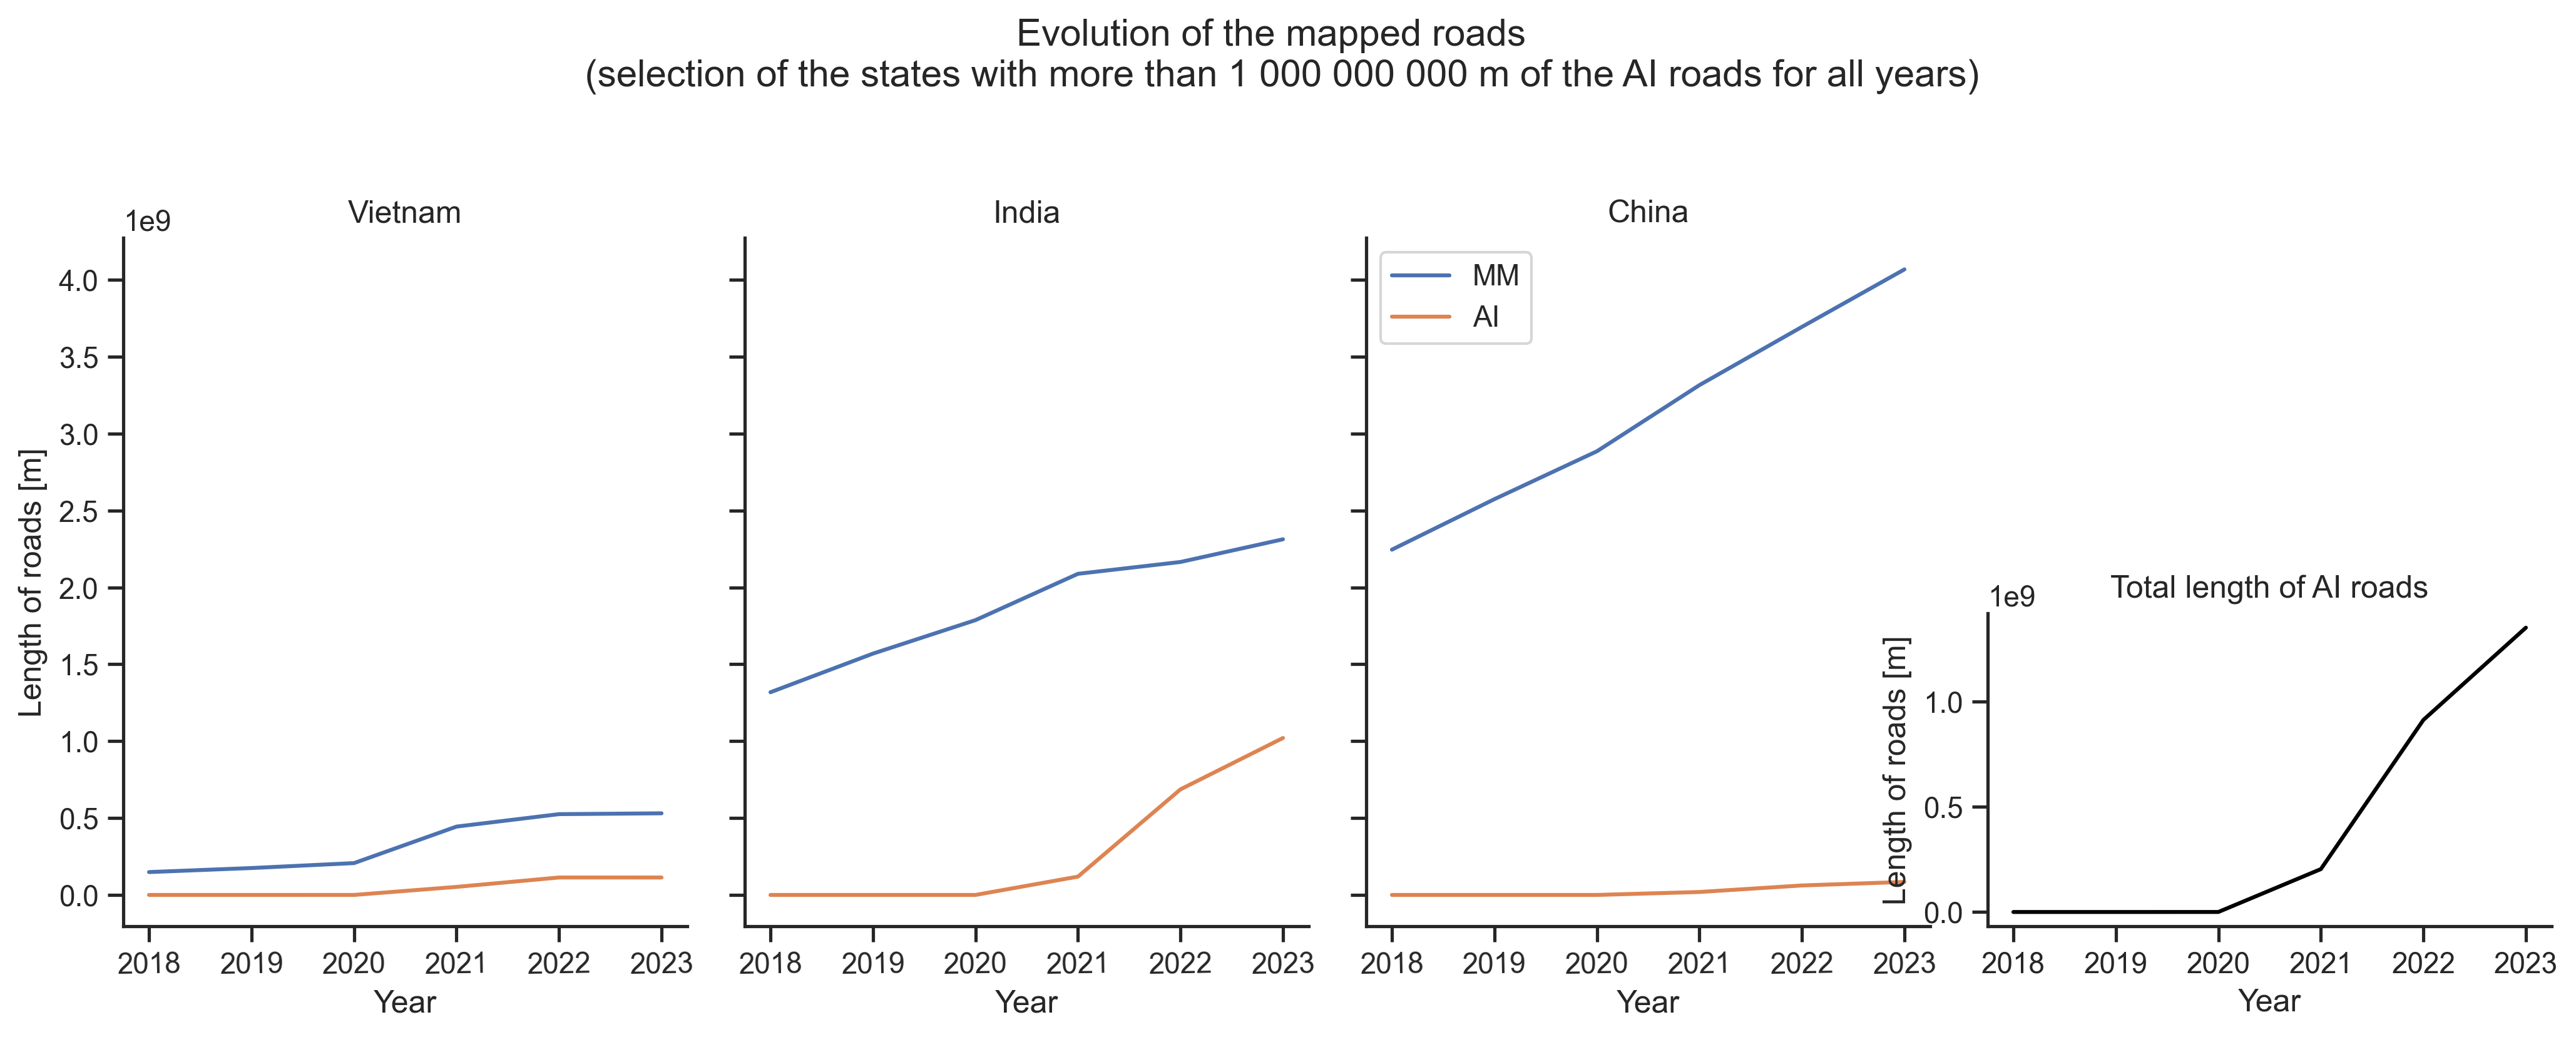

In [38]:

# create a FacetGrid for the first dataframe
g = sns.FacetGrid(data, col='name', hue='frame',
                col_wrap=4, 
                  height=1.5, aspect=2,
                  # gridspec_kws={"wspace": 0.2}
                  )


g = g.map(plt.plot, 'year', 'len_of_roads')

# plot the data on the FacetGrid

# g = g.map(plt.fill_between, 'year', 'len_of_roads', alpha=0.2)

# set the x-axis labels to be rotated
[plt.setp(ax.get_xticklabels(), rotation=1) for ax in g.axes.flat]

# set the titles for each subplot based on the 'name' column
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Evolution of the mapped roads \n (selection of the states with more than 1 000 000 000 m of the AI roads for all years)')

# set the axes titles and limits
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Length of roads [m]")
    # ax.set_ylim(100)



# create a new plot axis for the second dataframe
ax2 = plt.subplot(2, 4, 8)

# plot the data from the second dataframe on the new axis
sns.lineplot(data=df_ai_tot, x='year',
             y='total_roads', color='black', alpha=1, ax=ax2)

# set the title and axes labels for the new plot axis
ax2.set_title('Total length of AI roads')
ax2.set_xlabel('Year')
ax2.set_ylabel('Length of roads [m]')

# remove the top and right spines of all subplots
sns.despine()

# adjust the layout of the subplots
# plt.tight_layout()

# adjust the size of the figure
fig = plt.gcf()
fig.set_size_inches(14,9)

ax.legend(
    # loc='upper left', 
          # bbox_to_anchor=(1.1, 0.1)
          )

# show the plot
plt.show()


In [39]:
"""

# create a grid : initialize it
g = sns.FacetGrid(df_rem, col='name', hue='name', col_wrap=4,)

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'len_of_roads')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'len_of_roads',
          alpha=0.2)#.set_titles("{col_name}")

# plot the sum line over the plot
g = g.map(plt.plot, 'year', 'total_roads', color='red', alpha=0.2)

# g.set(ylim=(0, 100))

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the manually mapped roads')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Length of roads [m]")
    # ax.set_ylim(100)

# Show the graph
plt.show()


# create a grid : initialize it
g = sns.FacetGrid(df_ai, col='name', hue='name', col_wrap=4, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'len_of_roads')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'len_of_roads',
          alpha=0.2)  # .set_titles("{col_name}")

# plot the sum line over the plot
g = g.map(plt.plot, 'year', 'total_roads', color='red', alpha=0.2)

# g.set(ylim=(0,100))

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the Microsoft AI roads')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Length of roads [m]")

# show the graph
plt.show()

"""


'\n\n# create a grid : initialize it\ng = sns.FacetGrid(df_rem, col=\'name\', hue=\'name\', col_wrap=4,)\n\n# add the line over the area with the plot function\ng = g.map(plt.plot, \'year\', \'len_of_roads\')\n\n# fill the area with fill_between\ng = g.map(plt.fill_between, \'year\', \'len_of_roads\',\n          alpha=0.2)#.set_titles("{col_name}")\n\n# plot the sum line over the plot\ng = g.map(plt.plot, \'year\', \'total_roads\', color=\'red\', alpha=0.2)\n\n# g.set(ylim=(0, 100))\n\n# rotate the xticklabels\n[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]\n\n# set subtitles using the get_subtitle function\ng.set_titles("{col_name}")\n\n# add a title for the whole plot\nplt.subplots_adjust(top=0.92)\ng.fig.suptitle(\'Evolution of the manually mapped roads\')\n\n# set the axes titles\naxes = g.axes.flatten()\nfor ax in axes:\n    ax.set_xlabel("Year")\n    ax.set_ylabel("Length of roads [m]")\n    # ax.set_ylim(100)\n\n# Show the graph\nplt.show()\n\n\n# create a g